# Model and Dataset exploration using Streamlit

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import f_regression
import itertools

In [2]:
RANDOM_STATE = 42

## Feature Engineering

In [3]:
# Constant
drop_cols = []
obj_col = "target"
df_path = "data/heart.csv"
df = pd.read_csv(df_path)
features=df.drop(columns=['target' ])


## feature engineering
def feature_engineering(raw_df):
    #print(f'Original_df_shape = {df.shape}')
    target = raw_df[[obj_col]]
    corr = raw_df.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= 0.8:
                if columns[j]:
                    columns[j] = False
    selected_columns = raw_df.columns[columns]
    feature_ls = list(selected_columns)
    feature_ls.remove('target')
    features1 = df[feature_ls]
    #omit all features which have less than +-0.004 correlation with target
    corre = pd.DataFrame()
    # this not utilized
    for i in features1.columns:
        corre[i] = pearsonr(df.target, features1[i])
    corre1 = corre.T
    coore2 = corre1.iloc[:, 0].sort_values(ascending=False)
    new_features = coore2[np.abs(coore2) > 0.0004].index
    # Feature Selection based on importance

    F_values, p_values = f_regression(features, target)
    f_reg_results = list(itertools.zip_longest(features.columns, F_values, ['%.3f' % p for p in p_values]))
    f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
    f_reg_results = f_reg_results.sort_values(by=['P_Value'])
    f_reg_results.P_Value= f_reg_results.P_Value.astype(float)
    f_reg_results=f_reg_results[f_reg_results.P_Value<0.06]
    f_reg_list=f_reg_results.Variable.values
    final_features = list(set(f_reg_list) & set(new_features))
    final_data=pd.concat([df[final_features] ,target], axis=1)
    #print(f'Final_df_shape = {final_data.shape}')
    return final_data

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
# cat
def to_category(train_df, test_df):
    cat = []
    mappings = {}
    for col in cat:
        le = preprocessing.LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return train_df, test_df, mappings

In [6]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions = 1 * (y_proba >= t)
    return y_proba, predictions

## Metrics and Plots

In [7]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)

In [8]:
def get_metrics(y, ypred, yproba):
    return {
        "roc_auc": roc_auc_score(y, yproba),
        "average_precision": average_precision_score(y, yproba),
        "accuracy": accuracy_score(y, ypred),
        "precision": precision_score(y, ypred),
        "recall": recall_score(y, ypred),
        "f1": f1_score(y, ypred),
        "cm": confusion_matrix(y, ypred)
    }

In [9]:
def get_plots(y, ypred, yproba):
    cm = confusion_matrix(y, ypred)
    cm_plot = ConfusionMatrixDisplay(cm).plot()
    fpr, tpr, _ = roc_curve(y, yproba)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    prec, recall, _ = precision_recall_curve(y, yproba)
    pr_plot = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    return {
        'cm': cm_plot,
        'roc': roc_plot,
        'pr': pr_plot
    }

In [10]:
# evaluation
def eval_model(clf, X, y):
    y_proba, y_pred = get_predictions(clf, X)
    metrics = get_metrics(y, y_pred, y_proba)
    plots = get_plots(y, y_pred, y_proba)
    return metrics, plots

## Working On Actual Data

Our test set here actually has no ground truth. We'll thus use the original training set and split it up into train and validation.

In [11]:
df[obj_col]

0       0
1       0
2       0
3       0
4       0
       ..
1020    1
1021    0
1022    0
1023    1
1024    0
Name: target, Length: 1025, dtype: int64

In [12]:
print("Loading data...")
df_train = pd.read_csv(df_path)#.drop('target',axis=1)
#df_test = pd.read_csv(test_df_path)

print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
# test_df = feature_engineering(df_test).drop(drop_cols, axis=1)
# train_df, test_df, mappings = to_category(train_df, test_df)

Loading data...
Engineering features...


/Users/slackroo/Data_science/UNIV_ai/Projects/ml_ops_1_1/heart_disease/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
train_df

,slope,exang,thalach,thal,restecg,age,trestbps,chol,cp,oldpeak,sex,ca
0,2,0,168,3,1,52,125,212,0,1.0,1,2
1,0,1,155,3,0,53,140,203,0,3.1,1,0
2,0,1,125,3,1,70,145,174,0,2.6,1,0
3,2,0,161,3,1,61,148,203,0,0.0,1,1
4,1,0,106,2,1,62,138,294,0,1.9,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1020,2,1,164,2,1,59,140,221,1,0.0,1,0
1021,1,1,141,3,0,60,125,258,0,2.8,1,1
1022,1,1,118,2,0,47,110,275,0,1.0,1,1
1023,2,0,159,2,0,50,110,254,0,0.0,0,0


Here are the features in the data:

```
Age (age in years)
Sex (1 = male; 0 = female)
CP (chest pain type)
TRESTBPS (resting blood pressure (in mm Hg on admission to the hospital))
CHOL (serum cholestoral in mg/dl)
FPS (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
RESTECH (resting electrocardiographic results)
THALACH (maximum heart rate achieved)
EXANG (exercise induced angina (1 = yes; 0 = no))
OLDPEAK (ST depression induced by exercise relative to rest)
SLOPE (the slope of the peak exercise ST segment)
CA (number of major vessels (0-3) colored by flourosopy)
THAL (3 = normal; 6 = fixed defect; 7 = reversable defect)
TARGET (1 or 0)
```

In [14]:
mappings = {
    'sex':{'female':0 , 'male':1},
    'cp':{'cp1':0,'cp2':1,'cp3':2,'cp4':3},
    'fps':{'True':1,'False':0},
    'exang':{'Yes':1,'No':0}
}

In [15]:
mappings

{'sex': {'female': 0, 'male': 1},
 'cp': {'cp1': 0, 'cp2': 1, 'cp3': 2, 'cp4': 3},
 'fps': {'True': 1, 'False': 0},
 'exang': {'Yes': 1, 'No': 0}}

## Some EDA

In [16]:
df_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


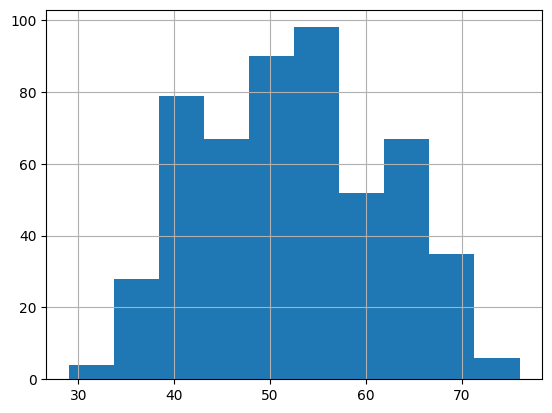

In [17]:
df_train[df_train.target == 1].age.hist()
plt.show()

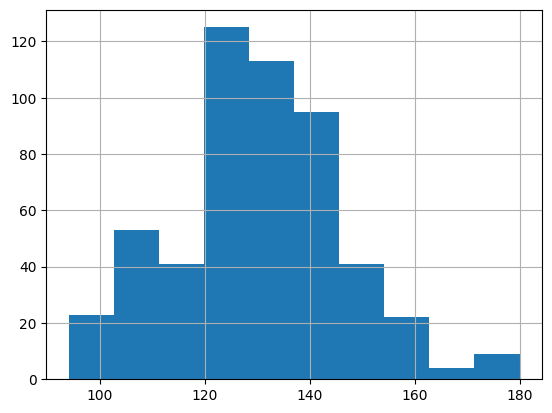

In [18]:
df_train[df_train.target == 1].trestbps.hist()
plt.show()

In [19]:
train_df = train_df.fillna(0)
#

In [20]:
train_df.head()

,slope,exang,thalach,thal,restecg,age,trestbps,chol,cp,oldpeak,sex,ca
0,2,0,168,3,1,52,125,212,0,1.0,1,2
1,0,1,155,3,0,53,140,203,0,3.1,1,0
2,0,1,125,3,1,70,145,174,0,2.6,1,0
3,2,0,161,3,1,61,148,203,0,0.0,1,1
4,1,0,106,2,1,62,138,294,0,1.9,0,3


In [21]:
train_df.describe()

,slope,exang,thalach,thal,restecg,age,trestbps,chol,cp,oldpeak,sex,ca
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000
mean,1.385366,0.336585,149.114146,2.323902,0.529756,54.434146,131.611707,246.00000,0.942439,1.071512,0.695610,0.754146
std,0.617755,0.472772,23.005724,0.620660,0.527878,9.072290,17.516718,51.59251,1.029641,1.175053,0.460373,1.030798
min,0.000000,0.000000,71.000000,0.000000,0.000000,29.000000,94.000000,126.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,132.000000,2.000000,0.000000,48.000000,120.000000,211.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,152.000000,2.000000,1.000000,56.000000,130.000000,240.00000,1.000000,0.800000,1.000000,0.000000
75%,2.000000,1.000000,166.000000,3.000000,1.000000,61.000000,140.000000,275.00000,2.000000,1.800000,1.000000,1.000000
max,2.000000,1.000000,202.000000,3.000000,2.000000,77.000000,200.000000,564.00000,3.000000,6.200000,1.000000,4.000000


## Model Training

We abuse the word test here: we really mean validation.

In [22]:
print("Training model...")
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

Training model...


In [23]:
def fit_model(train_X, train_y, max_depth=None, random_state=42):
    clf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, random_state=random_state)
    clf.fit(train_X, train_y)
    return clf

In [24]:
model = fit_model(X_train, y_train)

We save the model using joblib

In [25]:
print("Saving trained model...")
joblib.dump(model, "model.joblib")
print(type(model).__name__)
print(model.get_params())

Saving trained model...
RandomForestClassifier
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Inference

And we can carry out inference with a rehydrated model:

In [26]:
rehydrated = joblib.load("model.joblib")
type(rehydrated)

sklearn.ensemble._forest.RandomForestClassifier

In [27]:
df[:3]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [28]:
df[:3]#.shape

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [29]:
train_df.describe()

,slope,exang,thalach,thal,restecg,age,trestbps,chol,cp,oldpeak,sex,ca
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000
mean,1.385366,0.336585,149.114146,2.323902,0.529756,54.434146,131.611707,246.00000,0.942439,1.071512,0.695610,0.754146
std,0.617755,0.472772,23.005724,0.620660,0.527878,9.072290,17.516718,51.59251,1.029641,1.175053,0.460373,1.030798
min,0.000000,0.000000,71.000000,0.000000,0.000000,29.000000,94.000000,126.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,132.000000,2.000000,0.000000,48.000000,120.000000,211.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,152.000000,2.000000,1.000000,56.000000,130.000000,240.00000,1.000000,0.800000,1.000000,0.000000
75%,2.000000,1.000000,166.000000,3.000000,1.000000,61.000000,140.000000,275.00000,2.000000,1.800000,1.000000,1.000000
max,2.000000,1.000000,202.000000,3.000000,2.000000,77.000000,200.000000,564.00000,3.000000,6.200000,1.000000,4.000000


In [30]:
train_df.thal.value_counts(
)

thal
2    544
3    410
1     64
0      7
Name: count, dtype: int64

In [31]:
# {
#     'Sex':{'female':0 , 'male':1},
#     'CP':{'cp1':0,'cp2':1,'cp3':2,'cp4':3},
#     'FPS':{'True':1,'False':0},
#     'EXANG':{'Yes':1,'No':0}
# }
data_to_predict = dict(
    cp='cp1',
    ca=2,
    trestbps=143,
    thal=3,
    age=60,
    oldpeak=2.2,
    thalach=168,
    exang='Yes',
    sex='female',
    slope=2,
    restecg=1,
    chol=210
)

for k in data_to_predict:
    if k in ['sex', 'cp', 'fps', 'exang']:
        data_to_predict[k] = mappings[k][data_to_predict[k]]
data_to_predict


{'cp': 0,
 'ca': 2,
 'trestbps': 143,
 'thal': 3,
 'age': 60,
 'oldpeak': 2.2,
 'thalach': 168,
 'exang': 1,
 'sex': 0,
 'slope': 2,
 'restecg': 1,
 'chol': 210}

In [32]:
inputX = np.array(list(data_to_predict.values()))
inputX.reshape(1, -1)

array([[  0. ,   2. , 143. ,   3. ,  60. ,   2.2, 168. ,   1. ,   0. ,
          2. ,   1. , 210. ]])

In [33]:
rehydrated.predict(inputX.reshape(1, -1))

/Users/slackroo/Data_science/UNIV_ai/Projects/ml_ops_1_1/heart_disease/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])

In [34]:
rehydrated.predict(X_test)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,

## Metrics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating model...
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


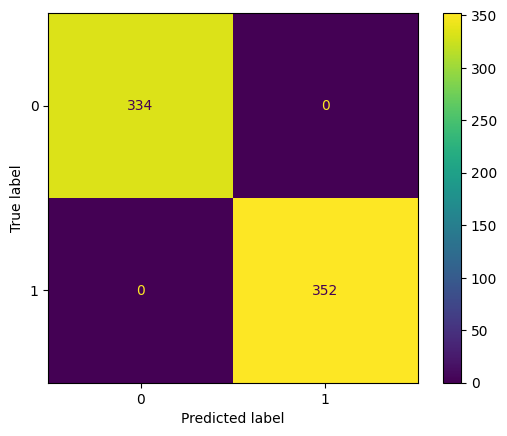

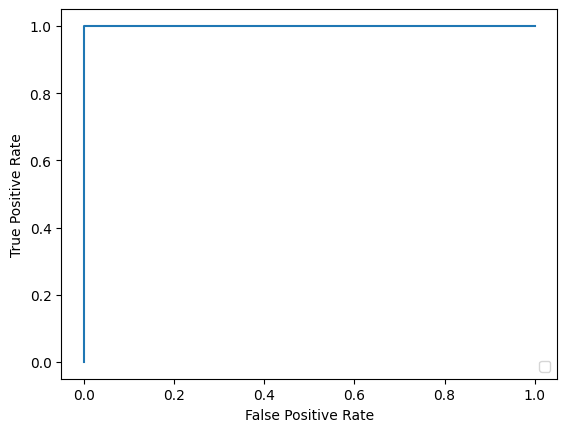

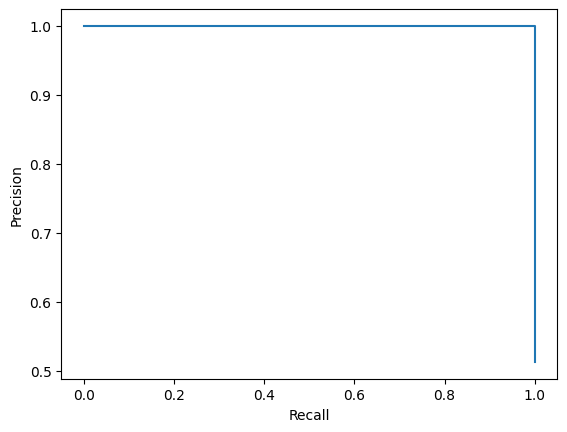

In [35]:
print("Evaluating model...")
train_metrics, train_plots = eval_model(model, X_train, y_train)
print("Train metrics:")
print(train_metrics)

In [36]:
for k in train_plots:
    print(k)
    f = train_plots[k]
    f.figure_.savefig(f"train_{k}.png")

cm
roc
pr


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9971786833855799, 'average_precision': 0.9976839938239838, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}


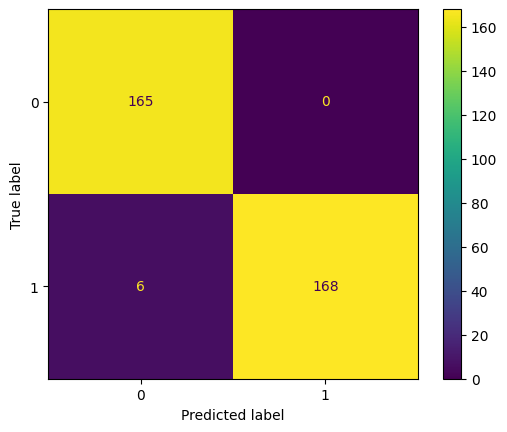

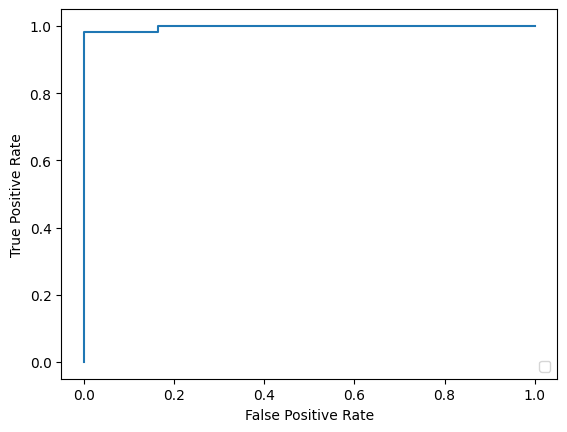

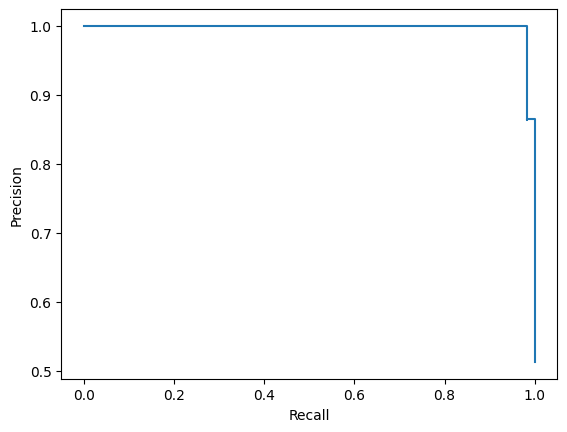

In [37]:
test_metrics, test_plots = eval_model(model, X_test, y_test)
print("Test metrics:")
print(test_metrics)

In [38]:
for k in test_plots:
    print(k)
    f = train_plots[k]
    f.figure_.savefig(f"test_{k}.png")

cm
roc
pr


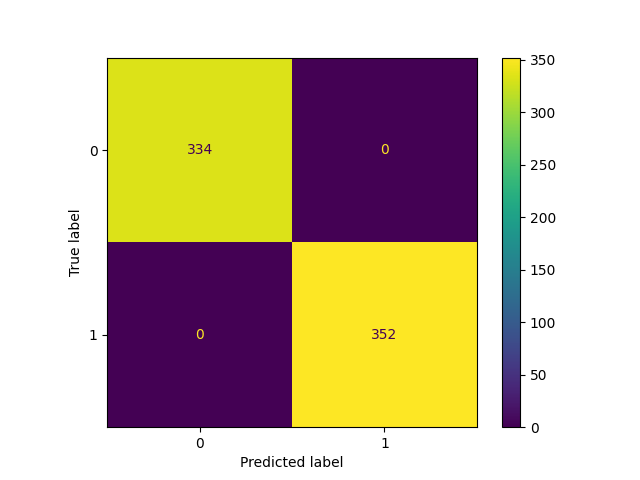

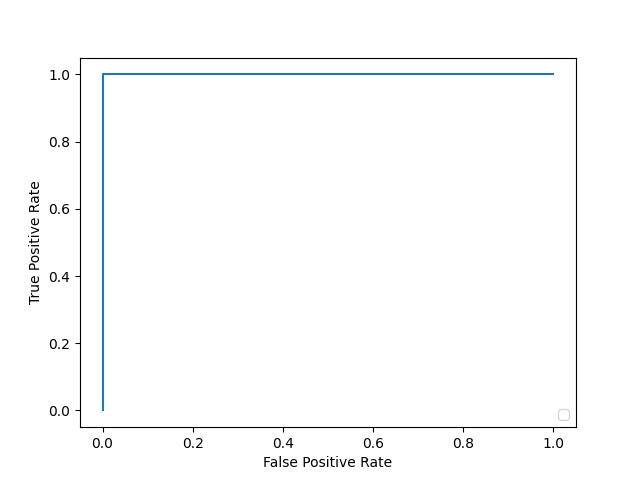

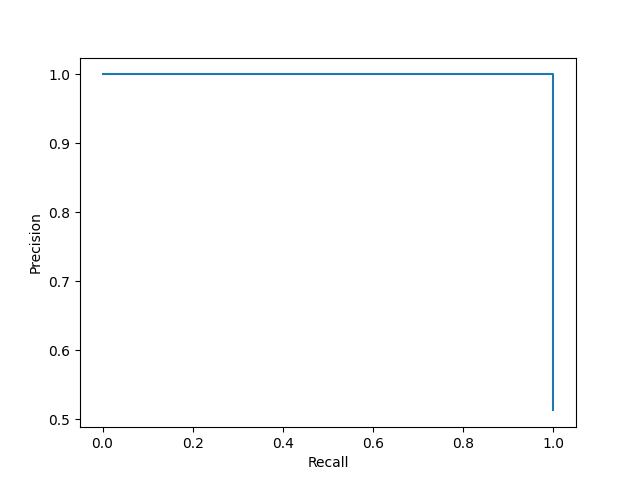

In [39]:
from IPython.display import Image, display

for k in test_plots:
    display(Image(f"test_{k}.png"))

## Now train with systematic hyperparameters

In [40]:
import uuid

In [41]:
!ls

Data              heart_disease     plots             test_pr.png
Intro.py          model.joblib      requirements.txt  test_roc.png
README.md         models            results.csv       train_cm.png
assets            models_old        simplemodel.ipynb train_pr.png
check_pages.py    pages             test_cm.png       train_roc.png


Training Model 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 0.9083296475231355, 'average_precision': 0.9012871155388147, 'accuracy': 0.8352769679300291, 'precision': 0.8040712468193384, 'recall': 0.8977272727272727, 'f1': 0.8483221476510067, 'cm': array([[257,  77],
       [ 36, 316]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.906478578892372, 'average_precision': 0.8777635429300217, 'accuracy': 0.8171091445427728, 'precision': 0.7947368421052632, 'recall': 0.867816091954023, 'f1': 0.8296703296703296, 'cm': array([[126,  39],
       [ 23, 151]])}
----------------------
Training Model 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 0.9935101388132824, 'average_precision': 0.9930242466529696, 'accuracy': 0.9416909620991254, 'precision': 0.9193548387096774, 'recall': 0.9715909090909091, 'f1': 0.9447513812154696, 'cm': array([[304,  30],
       [ 10, 342]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9758620689655173, 'average_precision': 0.9708216289832635, 'accuracy': 0.9321533923303835, 'precision': 0.9171270718232044, 'recall': 0.9540229885057471, 'f1': 0.9352112676056338, 'cm': array([[150,  15],
       [  8, 166]])}
----------------------
Training Model 8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 0.9999829885683179, 'average_precision': 0.99998388133443, 'accuracy': 0.9985422740524781, 'precision': 0.9971671388101983, 'recall': 1.0, 'f1': 0.9985815602836879, 'cm': array([[333,   1],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9948798328108673, 'average_precision': 0.9959445508669972, 'accuracy': 0.9734513274336283, 'precision': 0.9824561403508771, 'recall': 0.9655172413793104, 'f1': 0.9739130434782608, 'cm': array([[162,   3],
       [  6, 168]])}
----------------------
Training Model 10
Evaluating Model


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/slackroo/Data_science/UNIV_ai/Projects/ml_ops_1_1/heart_disease/lib/python3.10/site-packages/sklearn/utils/_plotting.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9973876698014629, 'average_precision': 0.9978339975740773, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}
----------------------
Training Model 12


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9971786833855799, 'average_precision': 0.9976839938239835, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}
----------------------
Training Model 15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9971786833855799, 'average_precision': 0.9976839938239838, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}
----------------------
Training Model 20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9971786833855799, 'average_precision': 0.9976839938239838, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}
----------------------
Training Model None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Evaluating Model
Train metrics:
{'roc_auc': 1.0, 'average_precision': 1.0, 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'cm': array([[334,   0],
       [  0, 352]])}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test metrics:
{'roc_auc': 0.9971786833855799, 'average_precision': 0.9976839938239838, 'accuracy': 0.9823008849557522, 'precision': 1.0, 'recall': 0.9655172413793104, 'f1': 0.9824561403508771, 'cm': array([[165,   0],
       [  6, 168]])}
----------------------


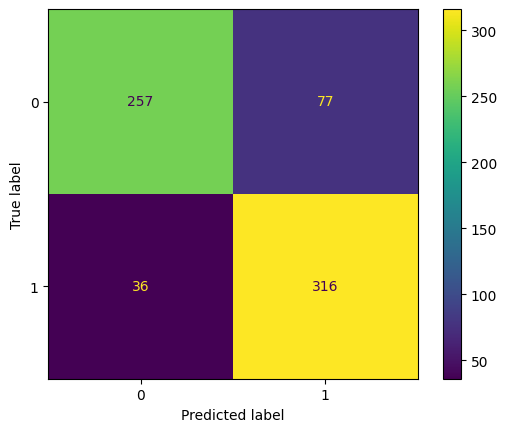

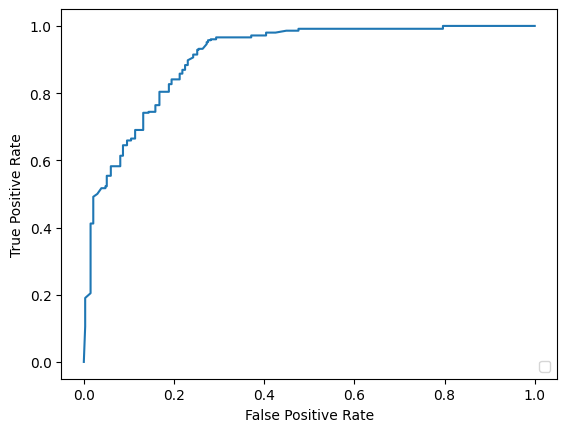

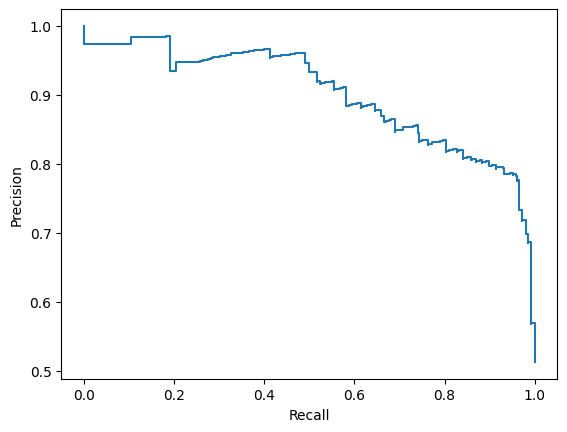

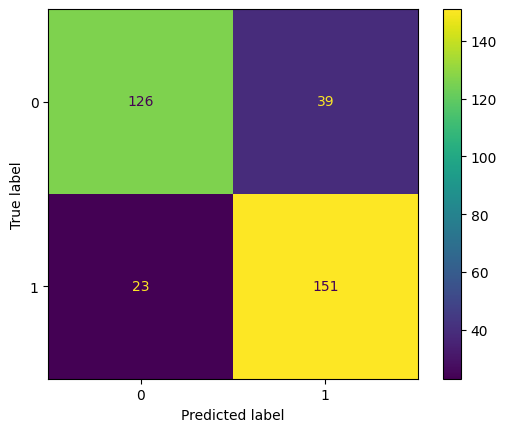

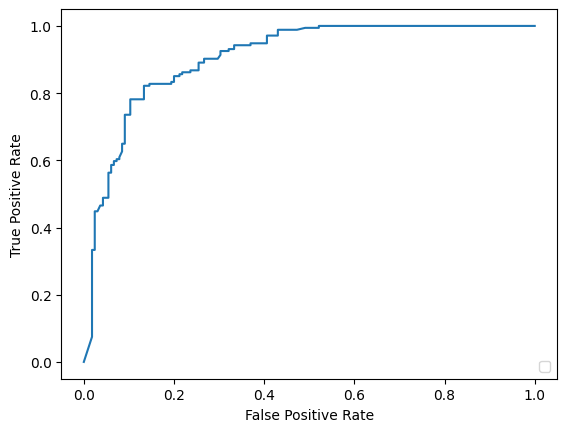

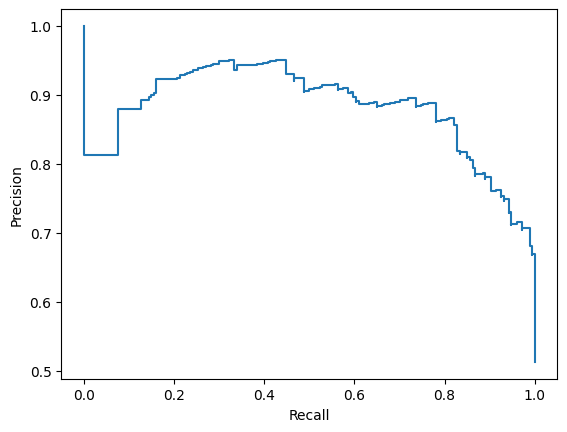

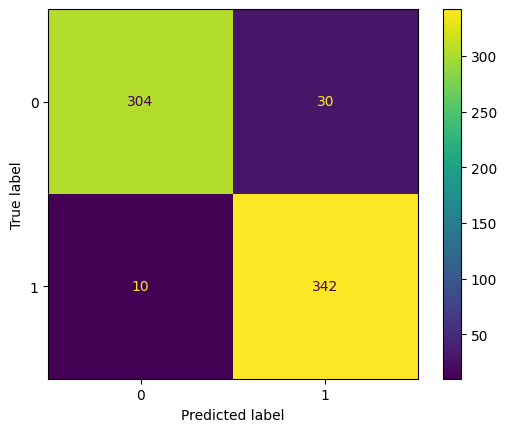

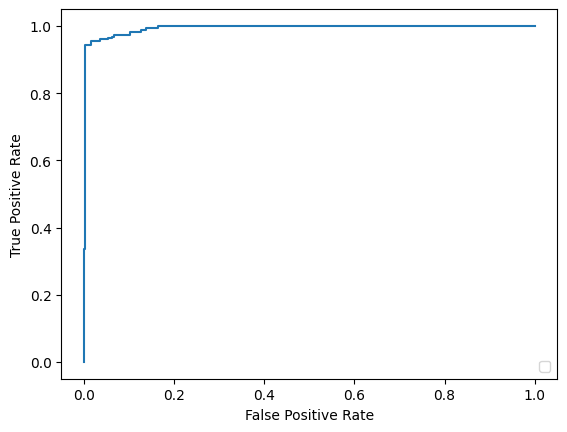

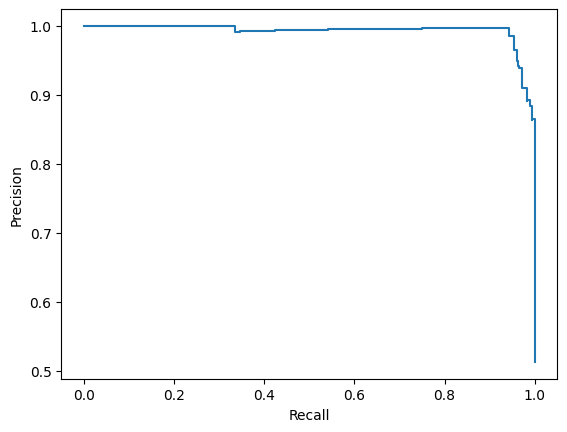

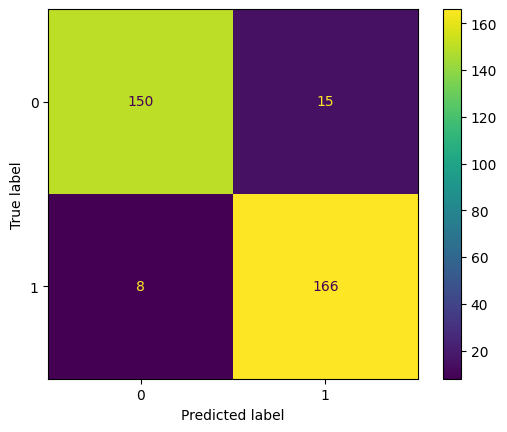

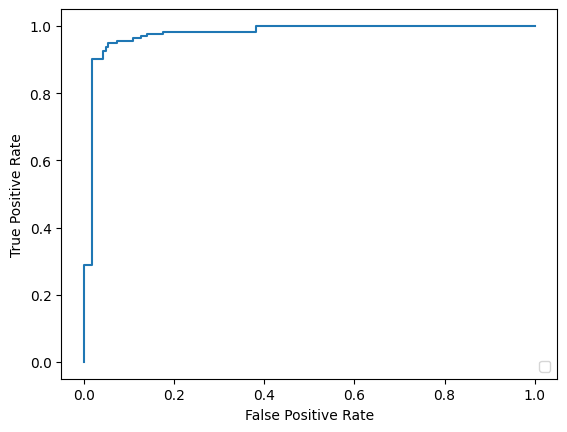

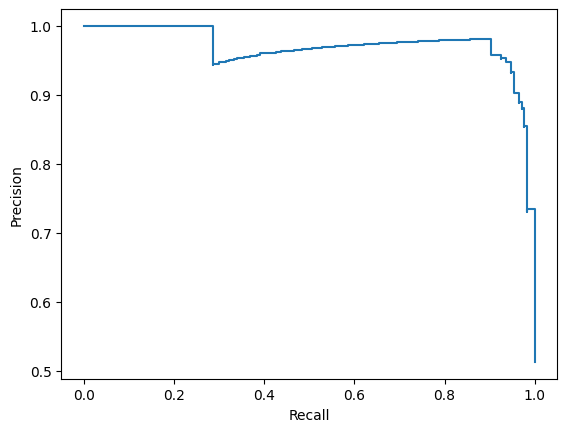

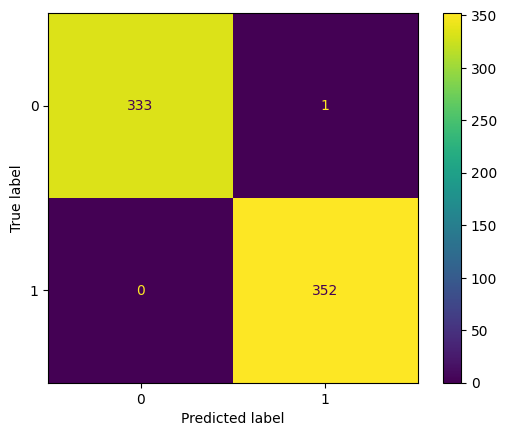

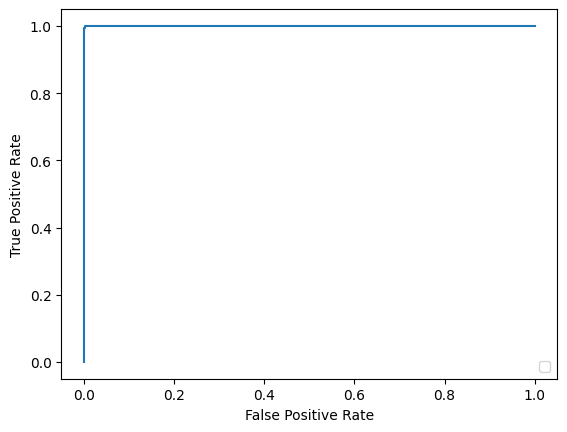

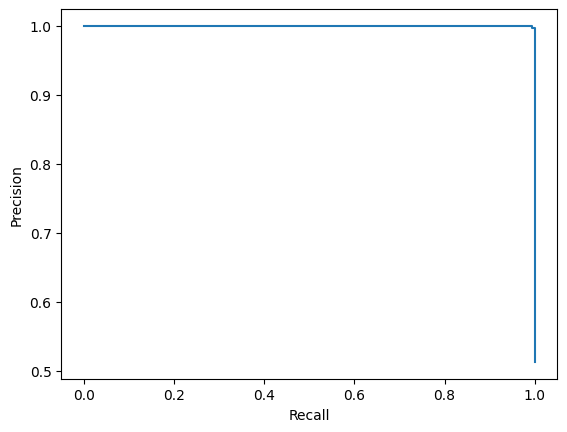

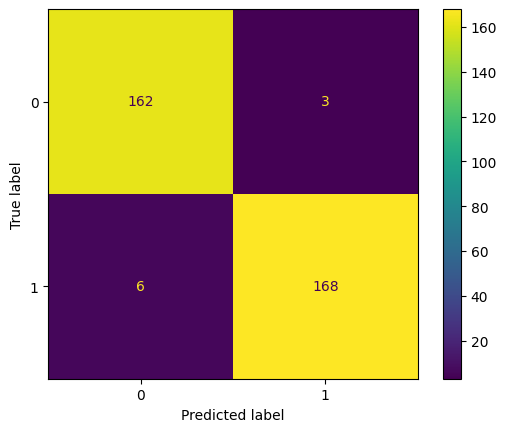

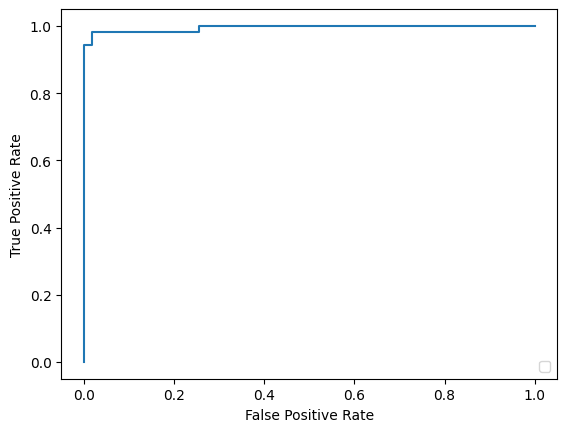

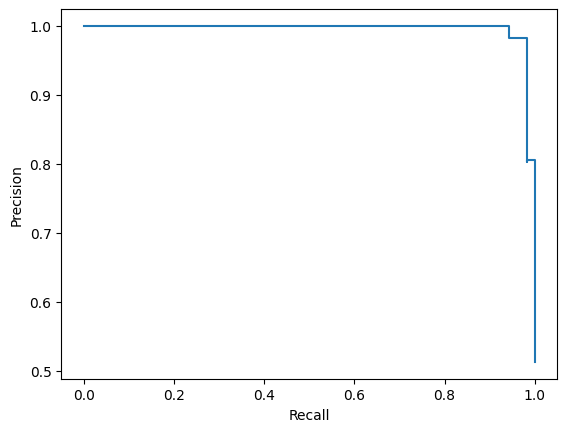

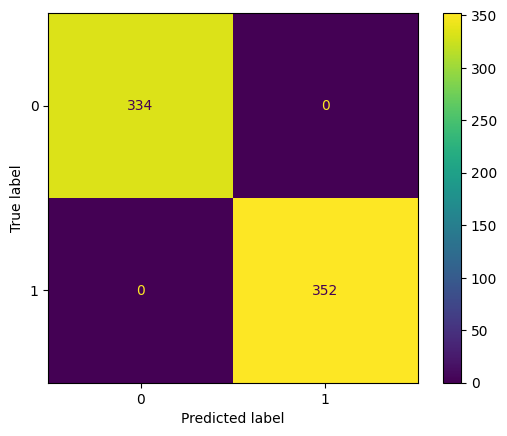

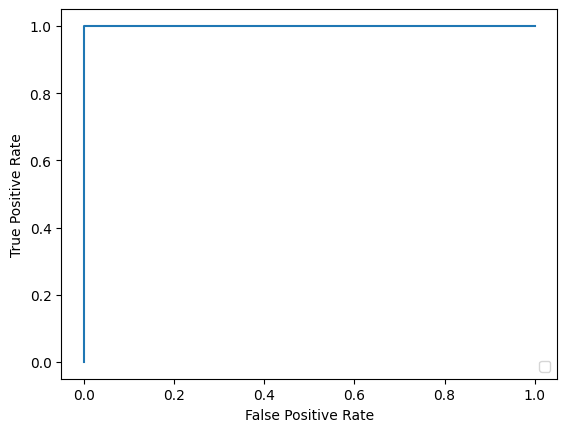

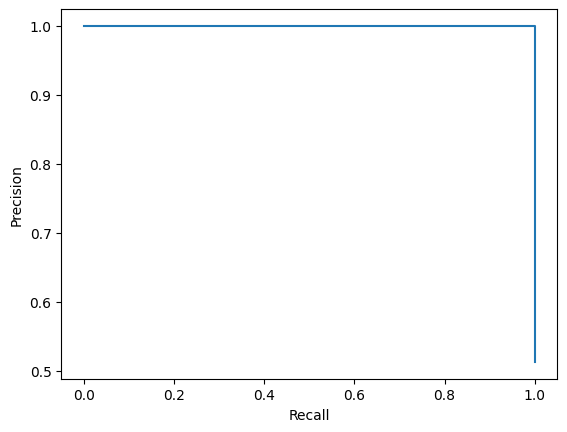

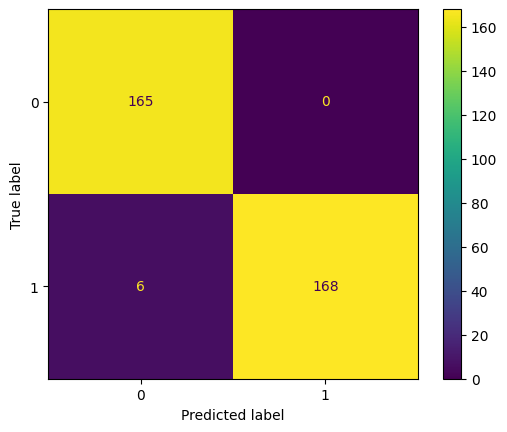

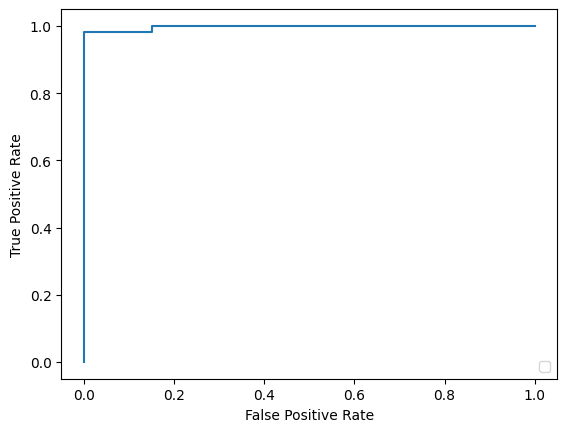

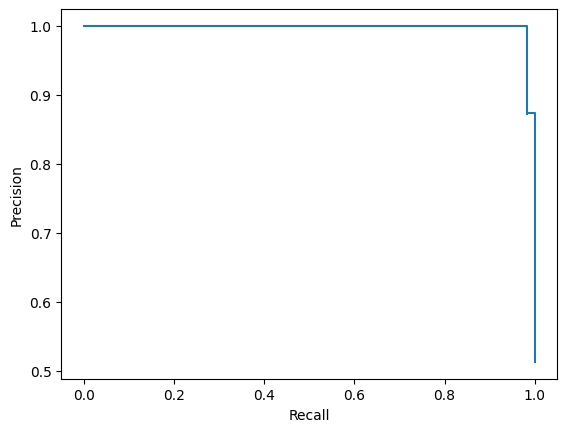

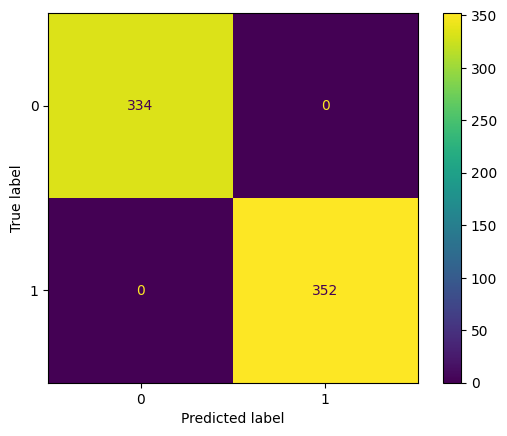

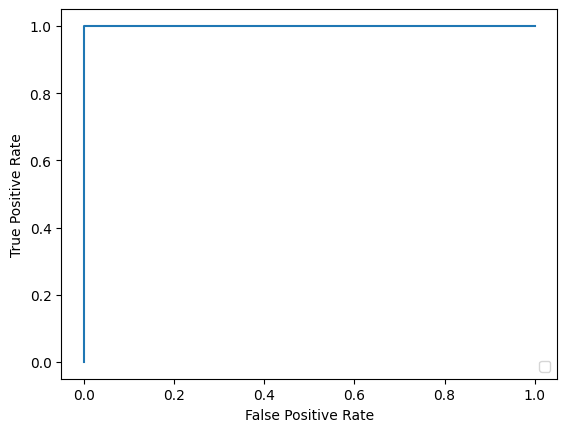

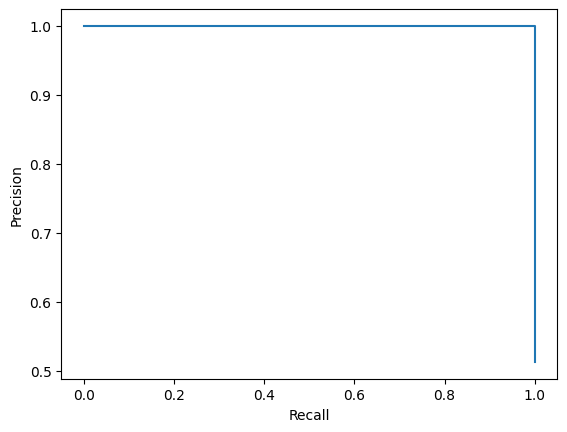

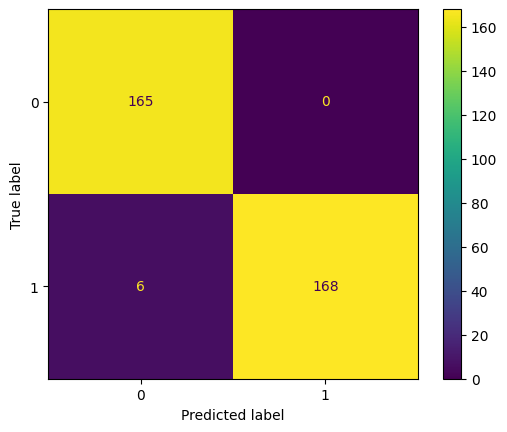

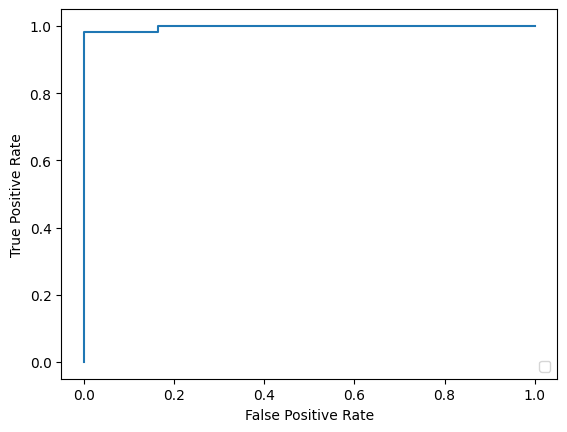

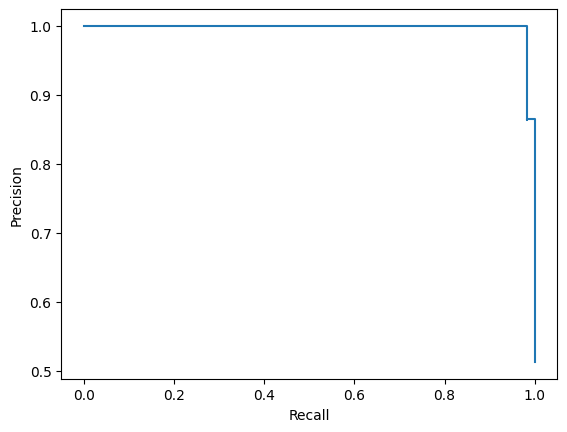

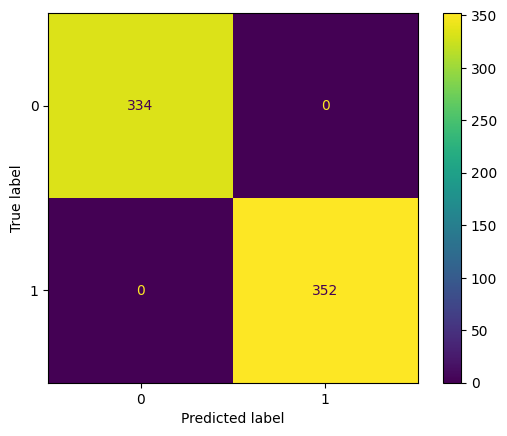

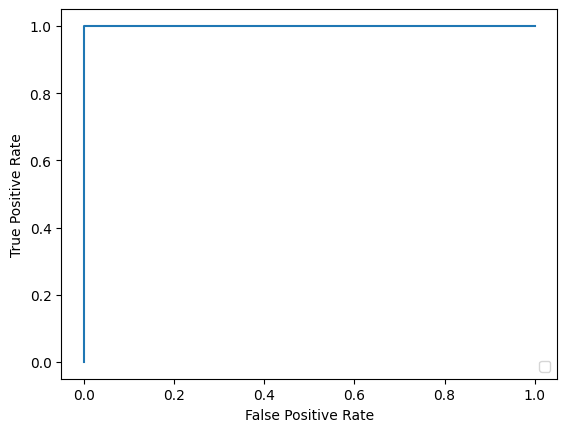

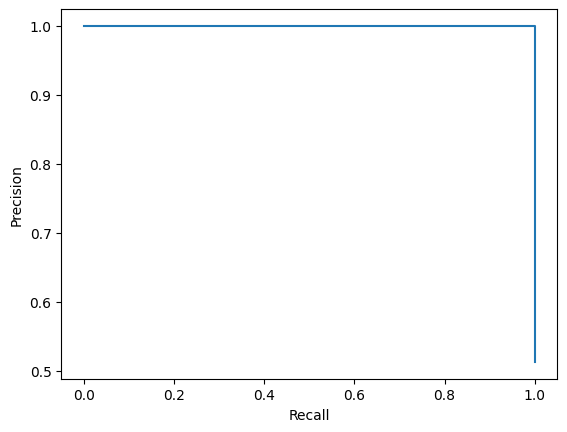

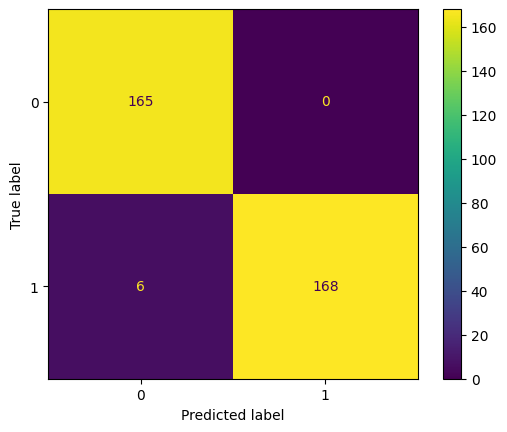

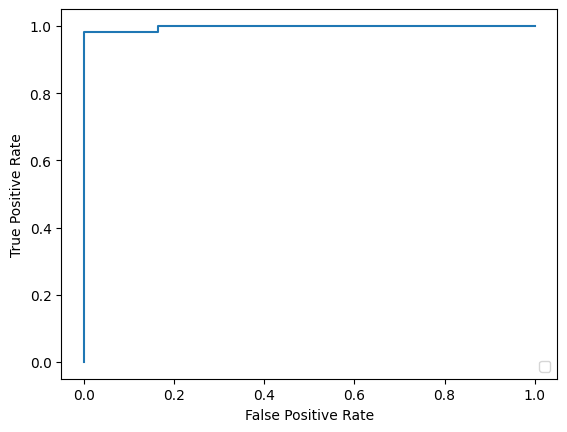

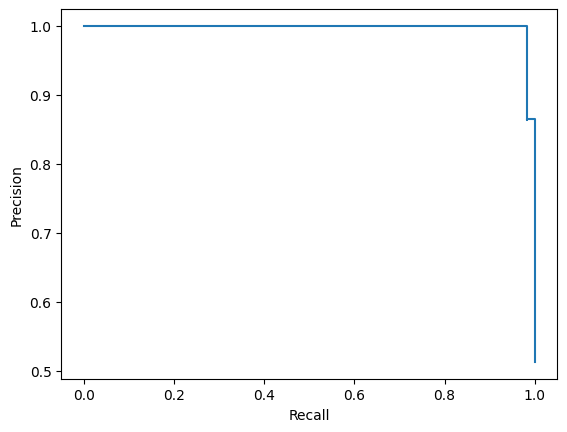

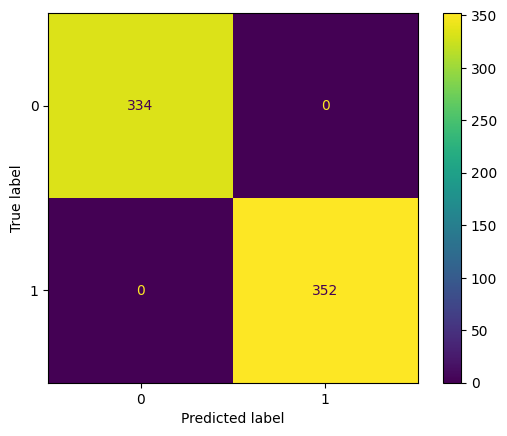

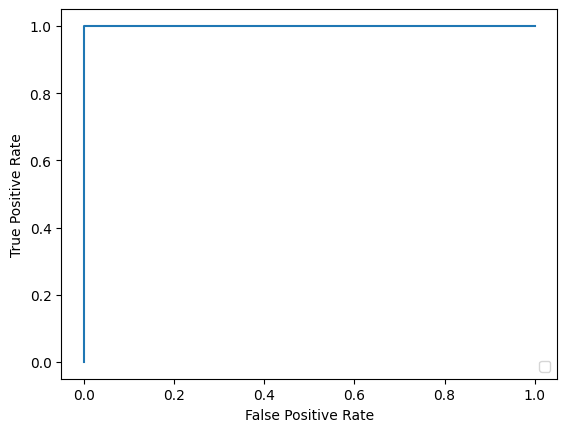

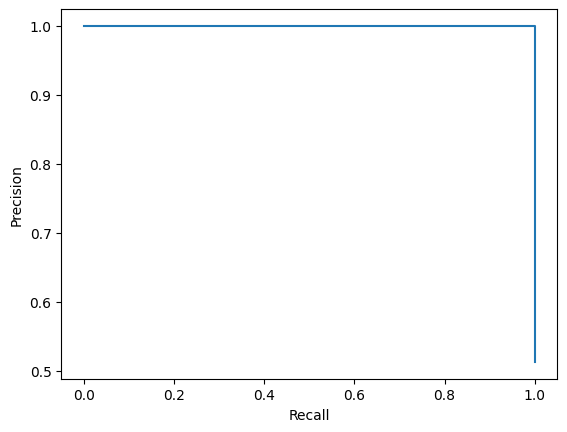

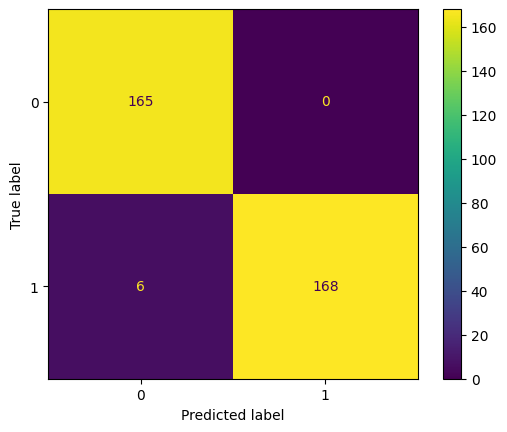

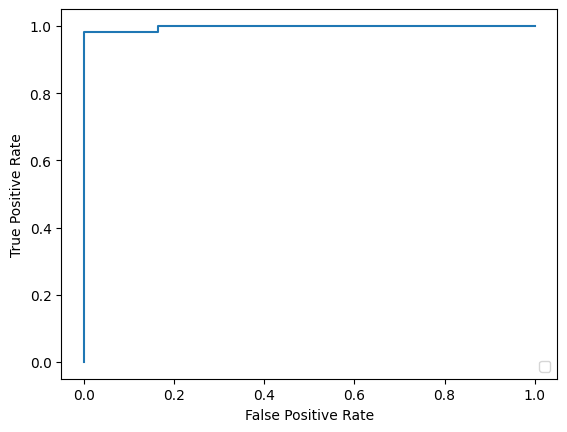

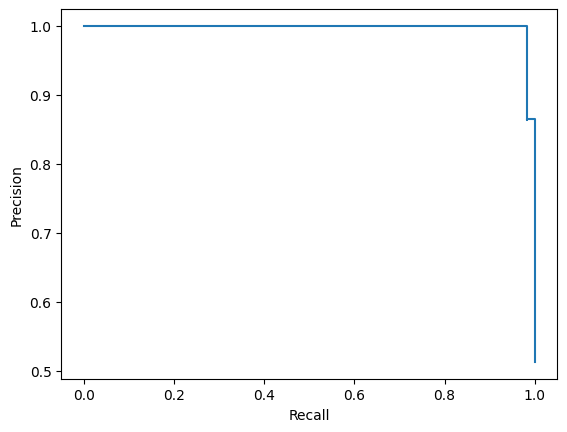

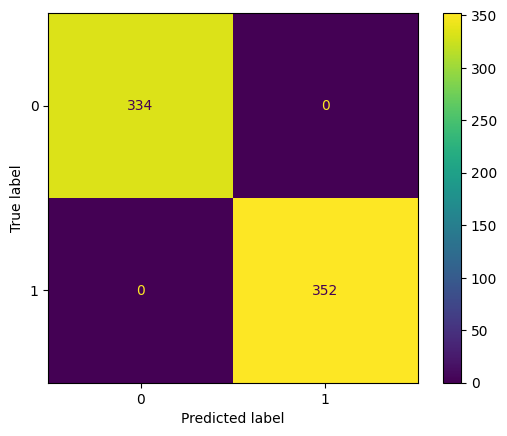

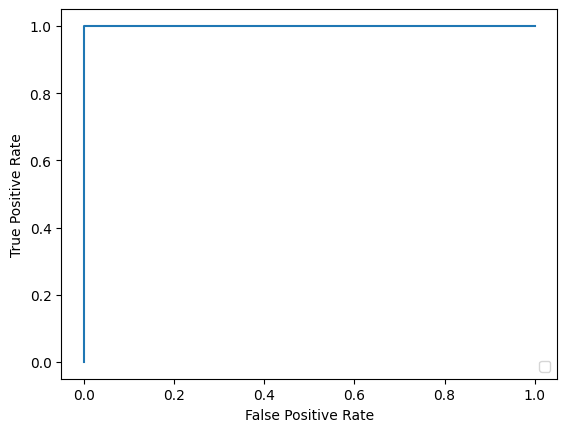

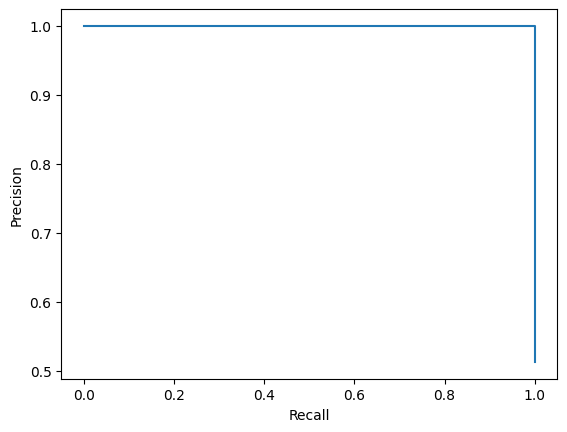

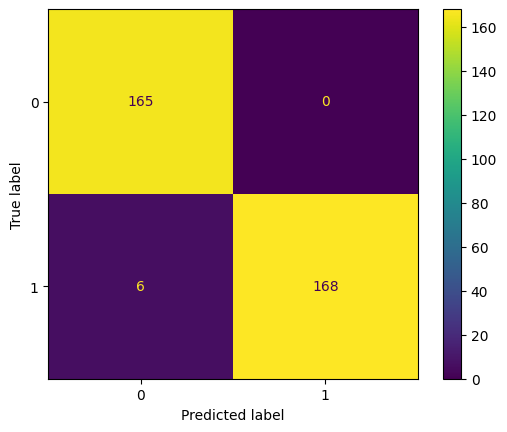

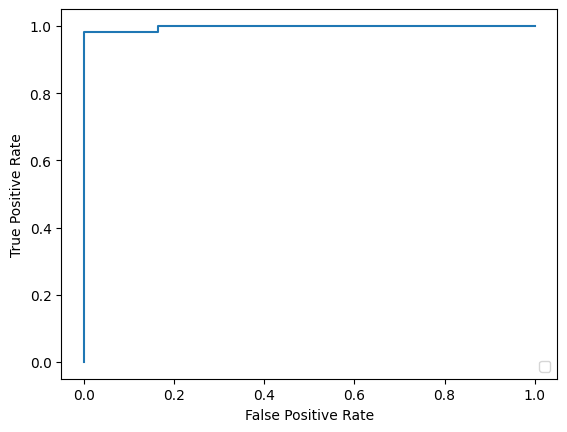

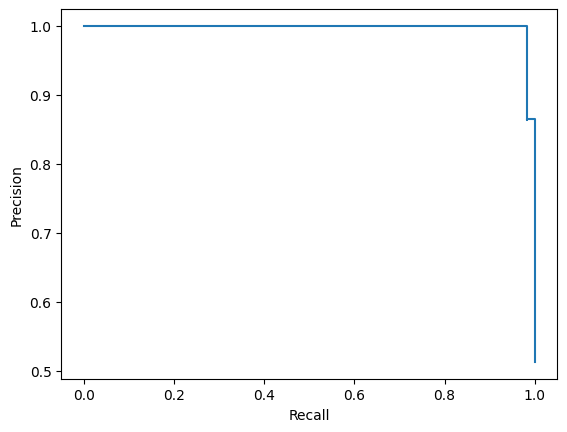

In [42]:
metrics = []
for max_depth in [1, 5, 8, 10, 12, 15, 20, None]:
    run_id = uuid.uuid4()
    print(f"Training Model {max_depth}")
    model = fit_model(X_train, y_train, max_depth=max_depth)
    print("Evaluating Model")
    train_metrics, train_plots = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_metrics)
    train_metrics['data'] = 'train'
    train_metrics['n_est'] = 200
    train_metrics['max_depth'] = max_depth
    train_metrics['run_id'] = run_id
    metrics.append(train_metrics)
    for k in train_plots:
        train_plots[k].figure_.savefig(f"plots/train_{run_id}_{k}.png")
    test_metrics, test_plots = eval_model(model, X_test, y_test)
    print("Test metrics:")
    print(test_metrics)
    test_metrics['data'] = 'test'
    test_metrics['n_est'] = 200
    test_metrics['max_depth'] = max_depth
    test_metrics['run_id'] = run_id
    metrics.append(test_metrics)
    for k in test_plots:
        test_plots[k].figure_.savefig(f"plots/test_{run_id}_{k}.png")
    joblib.dump(model, f"models/{run_id}.joblib")
    print('----------------------')

In [43]:
resudf = pd.DataFrame.from_records(metrics).set_index('run_id')
resudf

,roc_auc,average_precision,accuracy,precision,recall,f1,cm,data,n_est,max_depth
run_id,,,,,,,,,,
d762c211-dba2-4c5d-8567-bc7b34a4256c,0.908330,0.901287,0.835277,0.804071,0.897727,0.848322,"[[257, 77], [36, 316]]",train,200,1.0
d762c211-dba2-4c5d-8567-bc7b34a4256c,0.906479,0.877764,0.817109,0.794737,0.867816,0.829670,"[[126, 39], [23, 151]]",test,200,1.0
8e9a59e2-d828-4271-b31a-45c9e2eaa11b,0.993510,0.993024,0.941691,0.919355,0.971591,0.944751,"[[304, 30], [10, 342]]",train,200,5.0
8e9a59e2-d828-4271-b31a-45c9e2eaa11b,0.975862,0.970822,0.932153,0.917127,0.954023,0.935211,"[[150, 15], [8, 166]]",test,200,5.0
67d5e98a-784a-4510-85e3-8a176f5a2151,0.999983,0.999984,0.998542,0.997167,1.000000,0.998582,"[[333, 1], [0, 352]]",train,200,8.0
67d5e98a-784a-4510-85e3-8a176f5a2151,0.994880,0.995945,0.973451,0.982456,0.965517,0.973913,"[[162, 3], [6, 168]]",test,200,8.0
5e472b49-afeb-4cfb-a14d-dd47507bc831,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[[334, 0], [0, 352]]",train,200,10.0
5e472b49-afeb-4cfb-a14d-dd47507bc831,0.997388,0.997834,0.982301,1.000000,0.965517,0.982456,"[[165, 0], [6, 168]]",test,200,10.0
060a8ae0-e327-472e-b3b0-978efe6f123d,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[[334, 0], [0, 352]]",train,200,12.0


In [44]:
resudf.to_csv("results.csv", header=True)